In [1]:
from torchvision import datasets, transforms

# 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor()
])

# 下载训练集
train_dataset = datasets.MNIST(
    root='./data',  # 保存路径
    train=True,
    download=True,
    transform=transform
)

# 下载测试集
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        # input_dim: 输入维度（28*28=784）
        # hidden_dim: 隐藏层维度
        # latent_dim: 潜在变量维度
        super(VAE, self).__init__()
        
        # 编码器
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            # 输入层到隐藏层，全连接
            nn.Linear(input_dim, hidden_dim),
            # 激活函数ReLU
            nn.ReLU(),
            # 全连接层
            nn.Linear(hidden_dim, hidden_dim),
            # 激活函数ReLU
            nn.ReLU()
        )

        # 均值和对数方差的全连接层
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # 均值层
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # 对数方
        
        # 解码器
        self.decoder = nn.Sequential(
            # 潜在变量到隐藏层，全连接
            nn.Linear(latent_dim, hidden_dim),
            # 激活函数ReLU
            nn.ReLU(),
            # 全连接层
            nn.Linear(hidden_dim, hidden_dim),
            # 激活函数ReLU
            nn.ReLU(),
            # 输出层，全连接，输出维度为输入维度
            nn.Linear(hidden_dim, input_dim),
            # 激活函数Sigmoid，将输出限制在[0, 1]范围内
            nn.Sigmoid()
        )

    def encode(self, x):
        """编码器前向传播"""
        # 通过编码器网络获得隐藏表示
        h = self.encoder(x)
        #  计算均值和对数方差
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """重参数化技巧"""
        std = torch.exp(0.5 * logvar)  # 计算标准差
        eps = torch.randn_like(std)    # 采样标准正态分布
        return mu + eps * std          # 返回采样结果
    
    def decode(self, z):
        """解码过程"""
        x_recon = self.decoder(z)
        return x_recon
    
    def forward(self, x):
        """前向传播"""
        mu, logvar = self.encode(x)          # 编码
        z = self.reparameterize(mu, logvar)  # 重参数化采样
        x_recon = self.decode(z)             # 解码
        return x_recon, mu, logvar

In [3]:
def vae_loss_function(recon_x, x, mu, logvar):
    """计算VAE的损失函数"""
    # 重构损失，使用二元交叉熵，因为数据集是二值化的图像
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL散度
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # 返回总损失、重构损失和KL散度
    return BCE + KLD, BCE, KLD

In [4]:
# 确认一下确实跑在GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device  = "cpu"
print(f'Using device: {device}')

Using device: cuda


In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 设置数据加载器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 初始化模型
input_dim = train_dataset[0][0].numel()  # 28*28=784
hidden_dim = 400
latent_dim = 20
model = VAE(input_dim, hidden_dim, latent_dim)

# 定义优化器，使用Adam优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.to(device)


def train_epoch(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)  # 展平图像并移动到设备
        optimizer.zero_grad()  # 清零梯度，一是pytorch默认累计梯度，二是保证batch独立
        recon_batch, mu, logvar = model(data)  # 前向传播
        loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar)  # 计算损失
        loss.backward()  # 反向传播
        train_loss += loss.item()  # 累加损失
        optimizer.step()  # 更新参数
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}"
            )
    avg_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average loss: {avg_loss:.4f}")
    return avg_loss


def test_epoch(epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, input_dim).to(device)
            recon_batch, mu, logvar = model(data)
            loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()
    avg_loss = test_loss / len(test_loader.dataset)
    print(f"====> Test set loss: {avg_loss:.4f}")
    return avg_loss


def visualize_reconstructions():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.view(-1, input_dim).to(device)
        recon_batch, _, _ = model(data)

        n = 10  # 显示前10张图片
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # 原始图片
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(data[i].cpu().view(28, 28), cmap="gray")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # 重构图片
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_batch[i].cpu().view(28, 28), cmap="gray")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()


def generate_samples(num_samples=10):
    model.eval()
    with torch.no_grad():
        # 从标准正态分布中采样潜在变量
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z).cpu()

        plt.figure(figsize=(20, 4))
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            plt.imshow(samples[i].view(28, 28), cmap="gray")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()


def visualize_latent_space():
    model.eval()
    all_z = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.view(-1, input_dim).to(device)
            mu, logvar = model.encode(data)
            z = model.reparameterize(mu, logvar)
            all_z.append(z.cpu())
            all_labels.append(labels)

    all_z = torch.cat(all_z)
    all_labels = torch.cat(all_labels)

    if latent_dim == 2:
        z_np = all_z.numpy()
        labels_np = all_labels.numpy()
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            z_np[:, 0], z_np[:, 1], c=labels_np, cmap="tab10", alpha=0.7
        )
        plt.colorbar(scatter)
        plt.xlabel("z1")
        plt.ylabel("z2")
        plt.title("2D Latent Space Visualization")
        plt.show()
    else:
        from sklearn.decomposition import PCA

        z_np = all_z.numpy()
        labels_np = all_labels.numpy()

        pca = PCA(n_components=2)
        z_2d = pca.fit_transform(z_np)
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            z_2d[:, 0], z_2d[:, 1], c=labels_np, cmap="tab10", alpha=0.7
        )
        plt.colorbar(scatter)
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.title("Latent Space Visualization (PCA)")
        plt.show()

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.810852
Train Epoch: 1 [12800/60000 (21%)]	Loss: 200.668762
Train Epoch: 1 [25600/60000 (43%)]	Loss: 172.709671
Train Epoch: 1 [38400/60000 (64%)]	Loss: 161.313248
Train Epoch: 1 [51200/60000 (85%)]	Loss: 145.067383
====> Epoch: 1 Average loss: 178.4868
====> Test set loss: 137.8264
Train Epoch: 2 [0/60000 (0%)]	Loss: 138.872559
Train Epoch: 2 [12800/60000 (21%)]	Loss: 129.258789
Train Epoch: 2 [25600/60000 (43%)]	Loss: 131.932571
Train Epoch: 2 [38400/60000 (64%)]	Loss: 127.159775
Train Epoch: 2 [51200/60000 (85%)]	Loss: 128.847382
====> Epoch: 2 Average loss: 129.0452
====> Test set loss: 121.4582
Train Epoch: 3 [0/60000 (0%)]	Loss: 121.036850
Train Epoch: 3 [12800/60000 (21%)]	Loss: 120.673271
Train Epoch: 3 [25600/60000 (43%)]	Loss: 114.634583
Train Epoch: 3 [38400/60000 (64%)]	Loss: 116.006165
Train Epoch: 3 [51200/60000 (85%)]	Loss: 119.296417
====> Epoch: 3 Average loss: 118.5732
====> Test set loss: 114.1160
Train Epoch: 4 [0/60000 (0%)]	L

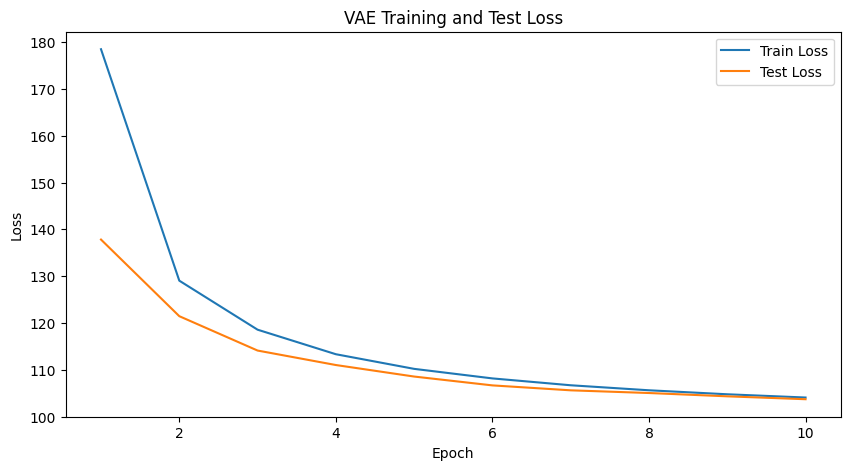

In [8]:
n_epochs = 10
train_losses = []
test_losses = []
for epoch in range(1, n_epochs + 1):
    train_loss = train_epoch(epoch)
    test_loss = test_epoch(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
# 可视化训练和测试损失
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training and Test Loss')
plt.legend()
plt.show()
torch.save(model.state_dict(), 'vae_mnist.pth')

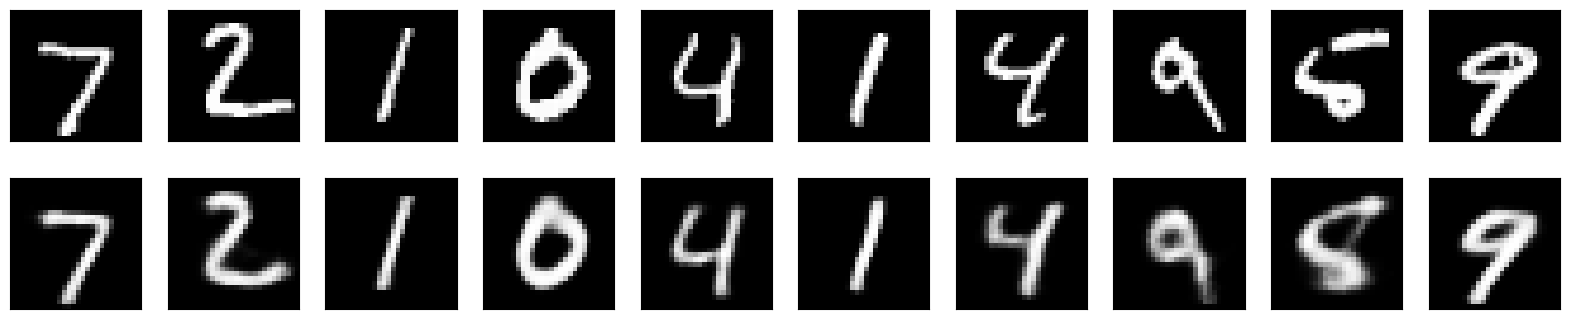

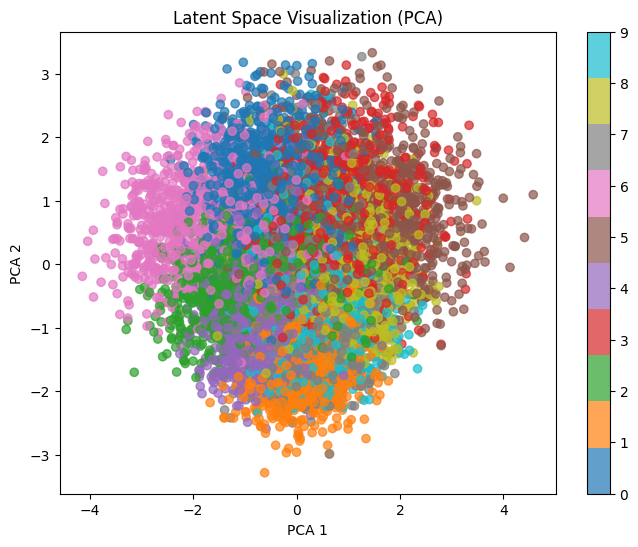

In [ ]:
visualize_reconstructions()
visualize_latent_space()

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# ==========================================
# 1. 基础辅助函数 (Loss & 展平处理)
# ==========================================

def safe_flatten(x):
    """确保输入被展平为 (batch_size, input_dim)"""
    if len(x.shape) > 2:
        return x.view(x.size(0), -1)
    return x

def default_vae_loss_function(recon_x, x, mu, logvar):
    """标准的 VAE Loss: Reconstruction + KLD"""
    # 确保输入平铺
    x_flat = safe_flatten(x)
    recon_x_flat = safe_flatten(recon_x)
    
    # 重建误差 (这里假设是二值数据用 BCE，如果是灰度/连续值可用 MSE)
    # reduction='sum' 意味着对整个 batch 求和
    BCE = F.binary_cross_entropy(recon_x_flat, x_flat, reduction='sum')
    
    # KL 散度
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

# ==========================================
# 2. 核心评估函数
# ==========================================

def estimate_marginal_likelihood(model, x, n_samples=100, device='cpu'):
    """
    使用重要性采样估计 log p(x)
    修复了形状不匹配的问题
    """
    model.eval()
    x = x.to(device)
    x = safe_flatten(x)  # <--- 关键修复：强制展平
    batch_size = x.shape[0]
    
    with torch.no_grad():
        # 1. q(z|x)
        mu, logvar = model.encode(x)
        std = torch.exp(0.5 * logvar)
        
        # 2. 采样 z (Batch, n_samples, latent_dim)
        # 扩展 mu 和 std 以便进行广播
        mu_exp = mu.unsqueeze(1)    # (B, 1, D)
        std_exp = std.unsqueeze(1)  # (B, 1, D)
        
        eps = torch.randn(batch_size, n_samples, model.latent_dim).to(device)
        z = mu_exp + eps * std_exp
        
        # 3. 计算 log q(z|x)
        # log_prob: (B, n_samples)
        log_q_z_given_x = -0.5 * (
            torch.log(2 * torch.tensor(np.pi)) + 
            2 * torch.log(std_exp) + 
            ((z - mu_exp) / std_exp)**2
        ).sum(dim=-1)
        
        # 4. 计算 log p(z) (先验是标准正态)
        log_p_z = -0.5 * (
            model.latent_dim * torch.log(2 * torch.tensor(np.pi)) + 
            (z**2).sum(dim=-1)
        )
        
        # 5. 计算 log p(x|z)
        # 需要将 z 展平送入 decode，然后再还原形状
        z_flat = z.view(batch_size * n_samples, -1)
        x_recon_flat = model.decode(z_flat)
        x_recon = x_recon_flat.view(batch_size, n_samples, -1)
        
        # 扩展 x 用于计算损失 (B, 1, input_dim)
        x_exp = x.unsqueeze(1)
        
        # 计算重建概率 (这里使用 BCE 的负值作为 log likehood)
        # 注意：这里假设输出经过了 Sigmoid。如果没有，需要用 MSE。
        # reduction='none' 保留每个样本的维度
        recon_loss = F.binary_cross_entropy(x_recon, x_exp.expand_as(x_recon), reduction='none').sum(dim=-1)
        log_p_x_given_z = -recon_loss
        
        # 6. log w = log p(x,z) - log q(z|x)
        log_w = log_p_z + log_p_x_given_z - log_q_z_given_x
        
        # 7. Log-Sum-Exp 技巧
        # log p(x) ≈ log(1/K * sum(exp(log_w)))
        #          = -log(K) + logsumexp(log_w)
        log_marginal_likelihood = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(n_samples, dtype=torch.float, device=device))
        
        return log_marginal_likelihood.mean().item()

def evaluate_metrics(model, test_loader, device='cpu', loss_fn=default_vae_loss_function):
    """计算基础指标：ELBO, Reconstruction Loss, KL"""
    model.eval()
    metrics = {'recon_loss': 0, 'kl_loss': 0, 'elbo': 0}
    total_samples = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            data_flat = safe_flatten(data) # 确保展平
            
            recon_batch, mu, logvar = model(data_flat)
            loss, recon, kl = loss_fn(recon_batch, data_flat, mu, logvar)
            
            metrics['elbo'] += -loss.item() # ELBO 是负的 Loss
            metrics['recon_loss'] += recon.item()
            metrics['kl_loss'] += kl.item()
            total_samples += data.size(0)
            
    # 平均化
    for k in metrics:
        metrics[k] /= total_samples
        
    return metrics

def calculate_wasserstein_score(model, test_loader, device='cpu', n_samples=1000):
    """计算真实特征和生成特征之间的 Wasserstein 距离"""
    model.eval()
    real_mus = []
    
    with torch.no_grad():
        # 获取真实数据的潜在分布
        for data, _ in test_loader:
            data = safe_flatten(data.to(device))
            mu, _ = model.encode(data)
            real_mus.append(mu.cpu().numpy())
            if len(real_mus) * data.shape[0] > n_samples: break
            
    real_mus = np.concatenate(real_mus)[:n_samples]
    
    # 从先验生成数据的潜在分布 (对于标准VAE，这里还是采样的 z)
    # 但为了对比分布一致性，通常对比 q(z|x) 和 p(z) 采样的解码后再编码有点复杂
    # 简单做法：对比 aggregate posterior q(z) 和 prior p(z) 的距离
    # 或者：对比真实图片特征 和 生成图片特征 (需要额外分类器，这里简化为对比潜在空间)
    
    # 这里我们对比：真实数据的潜在均值分布 vs 标准正态分布 (Prior)
    # 如果 VAE 训练得好，这两个应该很接近
    prior_samples = np.random.randn(n_samples, model.latent_dim)
    
    w_dists = [wasserstein_distance(real_mus[:, i], prior_samples[:, i]) 
               for i in range(model.latent_dim)]
    
    return np.mean(w_dists)

def calculate_reconstruction_quality(model, test_loader, device='cpu', n_batches=5):
    """计算 MSE 和 PSNR"""
    model.eval()
    mse_values = []
    psnr_values = []
    
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if i >= n_batches: break
            
            data = data.to(device)
            data_flat = safe_flatten(data)
            
            recon_flat, _, _ = model(data_flat)
            
            # 还原为图像计算 PSNR (0-1范围)
            # 假设数据已经是 [0,1]
            original = data_flat.cpu().numpy()
            recon = recon_flat.cpu().numpy()
            
            mse = ((original - recon)**2).mean(axis=1)
            mse_values.extend(mse)
            
            # PSNR = 20 * log10(MAX / sqrt(MSE))
            for m in mse:
                if m == 0: psnr_values.append(100)
                else: psnr_values.append(20 * np.log10(1.0 / np.sqrt(m)))
                
    return {
        'avg_mse': np.mean(mse_values),
        'avg_psnr': np.mean(psnr_values)
    }

def visualize_latent_interpolation(model, device='cpu'):
    """潜在空间插值可视化"""
    model.eval()
    z1 = torch.randn(1, model.latent_dim).to(device)
    z2 = torch.randn(1, model.latent_dim).to(device)
    
    steps = 10
    alphas = np.linspace(0, 1, steps)
    
    plt.figure(figsize=(15, 2))
    with torch.no_grad():
        for i, alpha in enumerate(alphas):
            z = (1 - alpha) * z1 + alpha * z2
            img_recon = model.decode(z).view(28, 28).cpu()
            
            plt.subplot(1, steps, i + 1)
            plt.imshow(img_recon, cmap='gray')
            plt.axis('off')
            plt.title(f'{alpha:.1f}')
    
    plt.suptitle("Latent Space Interpolation")
    plt.show()

def generate_new_samples(model, n_samples=16, device='cpu'):
    """生成新样本网格"""
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, model.latent_dim).to(device)
        samples = model.decode(z).view(-1, 28, 28).cpu()
        
        # 绘图
        grid_size = int(np.ceil(np.sqrt(n_samples)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
        for i, ax in enumerate(axes.flat):
            if i < n_samples:
                ax.imshow(samples[i], cmap='gray')
                ax.axis('off')
            else:
                ax.axis('off')
        plt.suptitle("Generated Samples p(x|z), z~N(0,I)")
        plt.show()

# ==========================================
# 3. 综合评估入口
# ==========================================

def comprehensive_evaluation(model, test_loader, device='cpu'):
    """
    重构后的综合评估函数，解决了 Shape Error
    """
    print("=" * 60)
    print("开始 VAE 模型综合评估")
    print("=" * 60)
    
    model.to(device)
    
    # 1. 基础 Loss 指标
    print("[1/5] 计算基础损失指标 (ELBO, Recon, KL)...")
    base_metrics = evaluate_metrics(model, test_loader, device)
    print(f"   Avg ELBO:       {base_metrics['elbo']:.4f}")
    print(f"   Avg Recon Loss: {base_metrics['recon_loss']:.4f}")
    print(f"   Avg KL Div:     {base_metrics['kl_loss']:.4f}")

    # 2. 边际似然估计 (重要性采样)
    print("\n[2/5] 估计对数边际似然 log p(x) (重要性采样)...")
    # 只取一个 batch 进行估计，避免太慢
    sample_data, _ = next(iter(test_loader))
    # 取前10个样本进行平均
    sample_subset = sample_data[:10] 
    
    # 这里的关键修复：estimate_marginal_likelihood 内部会处理 view/flatten
    ll_estimate = estimate_marginal_likelihood(model, sample_subset, n_samples=100, device=device)
    print(f"   Log Marginal Likelihood Estimate (IS): {ll_estimate:.4f}")

    # 3. 重建质量 (MSE/PSNR)
    print("\n[3/5] 评估图像重建质量...")
    recon_qual = calculate_reconstruction_quality(model, test_loader, device)
    print(f"   Avg MSE:  {recon_qual['avg_mse']:.6f}")
    print(f"   Avg PSNR: {recon_qual['avg_psnr']:.2f} dB")

    # 4. 生成质量 (Wasserstein)
    print("\n[4/5] 评估生成分布距离 (Wasserstein on Latent)...")
    w_dist = calculate_wasserstein_score(model, test_loader, device)
    print(f"   Avg Wasserstein Dist (Latent Real vs Prior): {w_dist:.4f}")

    # 5. 可视化
    print("\n[5/5] 生成可视化结果...")
    visualize_latent_interpolation(model, device)
    print("   绘制新生成样本...")
    generate_new_samples(model, n_samples=16, device=device)
    
    print("\n" + "=" * 60)
    print("评估完成")
    
    return {
        'base_metrics': base_metrics,
        'log_likelihood': ll_estimate,
        'reconstruction': recon_qual,
        'wasserstein': w_dist
    }


开始 VAE 模型综合评估
[1/5] 计算基础损失指标 (ELBO, Recon, KL)...
   Avg ELBO:       -103.5665
   Avg Recon Loss: 84.6556
   Avg KL Div:     18.9110

[2/5] 估计对数边际似然 log p(x) (重要性采样)...
   Log Marginal Likelihood Estimate (IS): -95.9467

[3/5] 评估图像重建质量...
   Avg MSE:  0.015659
   Avg PSNR: 18.69 dB

[4/5] 评估生成分布距离 (Wasserstein on Latent)...
   Avg Wasserstein Dist (Latent Real vs Prior): 0.4335

[5/5] 生成可视化结果...


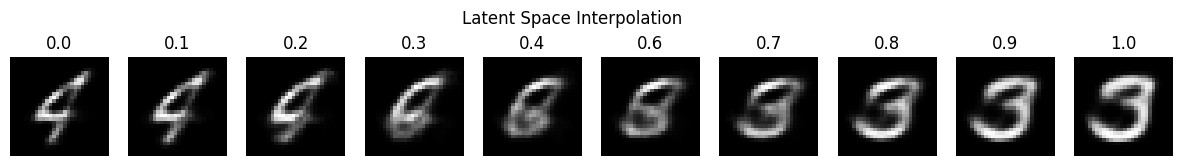

   绘制新生成样本...


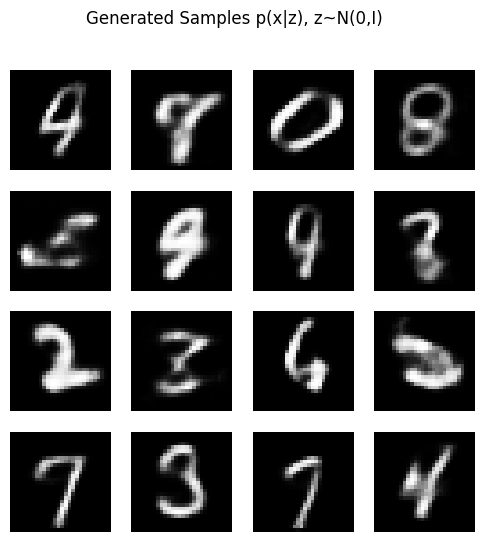


评估完成


In [ ]:
results = comprehensive_evaluation(model, test_loader, device)